# Import dataset and library

In [124]:
# import data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [125]:
#import data
accident_data = pd.read_csv("US_Accidents_MA.csv")

# Data preprocessing

Step 1：Drop irrelevant columns

In [126]:
# Irrelevant columns
# ID is unique and meaningless for the dataset; Description: I don't do text mining, and I will do text classification later, therefore It's useless; Country: All the data is from MA ;Weather_Timestamp: The timestamp of weather observation record. It's useless here.
irrelavant_columns = ['ID','Description','Country','State','Weather_Timestamp']
data_preprocessed_df = accident_data.drop(irrelavant_columns, axis=1)

Step 2: Drop the column with Missing Value(>40%)

In [127]:
# Replace the empty data with NaN
data_preprocessed_df.replace("", float("NaN"), inplace=True)
data_preprocessed_df.replace(" ", float("NaN"), inplace=True)

# Count missing value(NaN, na, null, None) of each columns, Then transform the result to a pandas dataframe. 
count_missing_value = data_preprocessed_df.isna().sum() / data_preprocessed_df.shape[0] * 100
count_missing_value_df = pd.DataFrame(count_missing_value.sort_values(ascending=False), columns=['Missing%'])

Text(0, 0.5, 'Features')

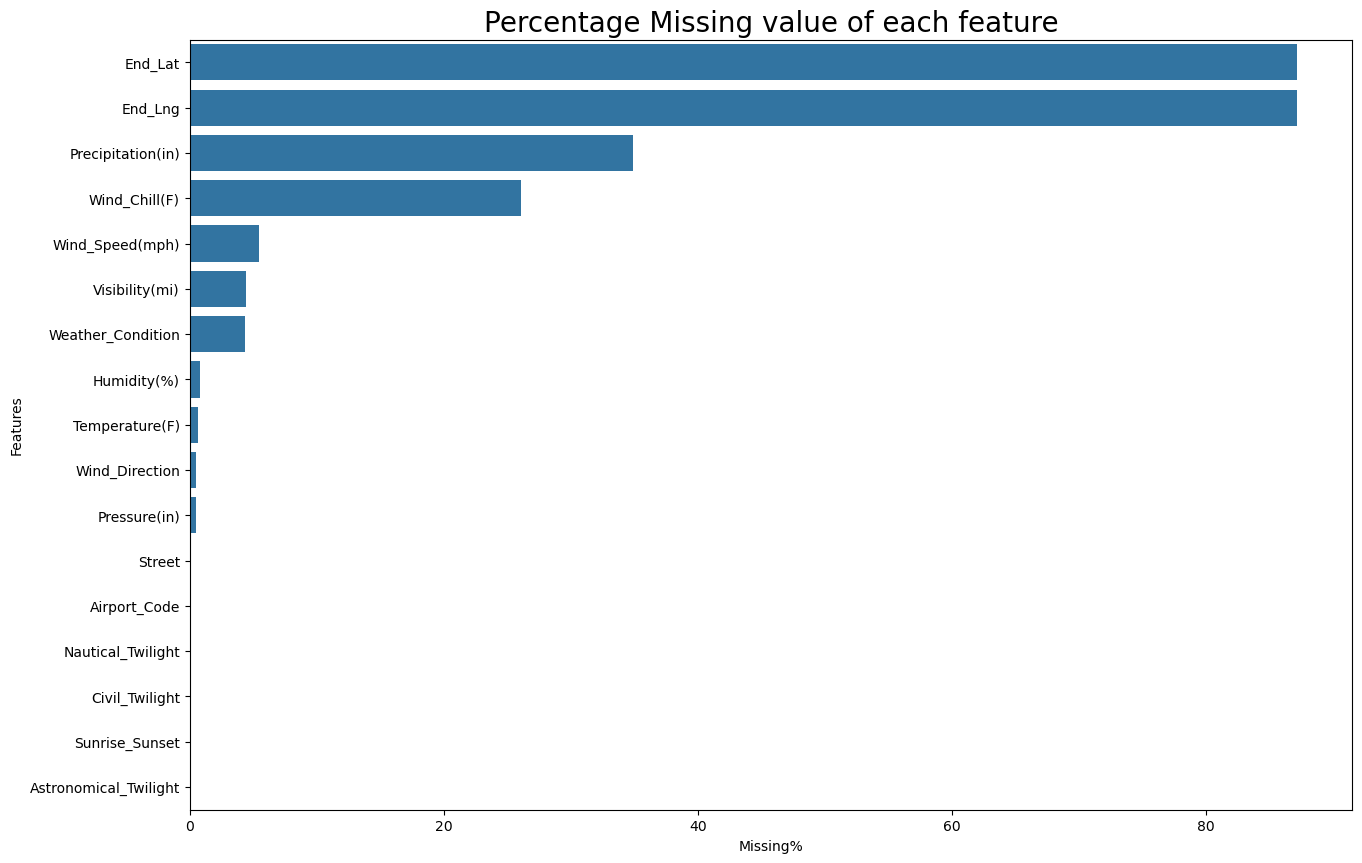

In [128]:
# Visualize the percentage(>0) of Missing value in each column.
missing_value_df = count_missing_value_df[count_missing_value_df['Missing%'] > 0]

plt.figure(figsize=(15, 10)) # Set the figure size
missing_value_graph = sns.barplot(y = missing_value_df.index, x = "Missing%", data=missing_value_df, orient="h")
missing_value_graph.set_title("Percentage Missing value of each feature", fontsize = 20)
missing_value_graph.set_ylabel("Features")

In [129]:
## Drop the column with Missing value(>40%)
missing_value_40_df = count_missing_value_df[count_missing_value_df['Missing%'] > 40]
data_preprocessed_df.drop(missing_value_40_df.index, axis=1, inplace=True)

Step 3: Data type correcting

In [130]:
# Convert Time to datetime64[ns]
data_preprocessed_df['Start_Time'] = pd.to_datetime(data_preprocessed_df['Start_Time'], format='mixed', errors='coerce')
data_preprocessed_df['End_Time'] = pd.to_datetime(data_preprocessed_df['End_Time'], format='mixed', errors='coerce')

Step 4: Median imputation

In [131]:
# Categorize the missing value to numerical and categorical for imputation purpose
numerical_missing = ['Wind_Speed(mph)', 'Visibility(mi)','Humidity(%)', 'Temperature(F)', 'Pressure(in)']
categorical_missing = ['Weather_Condition','Wind_Direction', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']

In [132]:
# Imputation by corresponding class Median value 
data_preprocessed_median_df = data_preprocessed_df.copy()

# For numerical columns
for column_name in numerical_missing:
    data_preprocessed_median_df[column_name] = data_preprocessed_median_df.groupby('Severity')[column_name].transform(lambda x:x.fillna(x.median()))

# # For categorical columns(Majority value imputation)
for column_name in categorical_missing:
    data_preprocessed_median_df[column_name] = data_preprocessed_median_df.groupby('Severity')[column_name].transform(lambda x:x.fillna(x.fillna(x.mode().iloc[0])))

# Drop NaN and reset index
data_preprocessed_median_df.dropna(inplace=True)


# Featrue Engineering

In [133]:
# Choose relevant features
data_best_df = data_preprocessed_median_df
relevant_features = ['Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
       'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)',
       'Wind_Direction', 'Wind_Speed(mph)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop']
data_modelling_df = data_best_df[relevant_features].copy()


Step 1: Create Duration feature 

In [134]:
# Duration = End_Time - Start_Time; Create a new feature for modeling.
data_modelling_df['Duration'] = (data_modelling_df['End_Time'] - data_modelling_df['Start_Time']).dt.total_seconds() / 3600
data_modelling_df.drop('End_Time', axis=1, inplace=True)

Step 2: Transform Month/week/Hour to different features

In [135]:
# Transform Month/week/Hour to different features
data_modelling_df["Month"] = data_modelling_df["Start_Time"].dt.month
data_modelling_df["Week"] = data_modelling_df["Start_Time"].dt.dayofweek
data_modelling_df["Hour"] = data_modelling_df["Start_Time"].dt.hour
data_modelling_df.drop("Start_Time", axis=1, inplace=True)

Step 3: Do one hot encoding to wind directions and weathrer conditions

In [136]:
# Select features that are suitable for One Hot Encoding
one_hot_features = ['Wind_Direction', 'Weather_Condition']

In [137]:
# Wind_Direction Categorizing
data_modelling_df.loc[data_modelling_df['Wind_Direction'].str.startswith('C'), 'Wind_Direction'] = 'C' #Calm
data_modelling_df.loc[data_modelling_df['Wind_Direction'].str.startswith('E'), 'Wind_Direction'] = 'E' #East, ESE, ENE
data_modelling_df.loc[data_modelling_df['Wind_Direction'].str.startswith('W'), 'Wind_Direction'] = 'W' #West, WSW, WNW
data_modelling_df.loc[data_modelling_df['Wind_Direction'].str.startswith('S'), 'Wind_Direction'] = 'S' #South, SSW, SSE
data_modelling_df.loc[data_modelling_df['Wind_Direction'].str.startswith('N'), 'Wind_Direction'] = 'N' #North, NNW, NNE
data_modelling_df.loc[data_modelling_df['Wind_Direction'].str.startswith('V'), 'Wind_Direction'] = 'V' #Variable

In [138]:
# Weather_Condition Categorizing
# Fair, Cloudy, Clear, Overcast, Snow, Haze, Rain, Thunderstorm, Windy, Hail, Thunder, Dust, Tornado
data_modelling_df['Weather_Fair'] = np.where(data_modelling_df['Weather_Condition'].str.contains('Fair', case=False, na = False), 1, 0)
data_modelling_df['Weather_Cloudy'] = np.where(data_modelling_df['Weather_Condition'].str.contains('Cloudy', case=False, na = False), 1, 0)
data_modelling_df['Weather_Clear'] = np.where(data_modelling_df['Weather_Condition'].str.contains('Clear', case=False, na = False), 1, 0)
data_modelling_df['Weather_Overcast'] = np.where(data_modelling_df['Weather_Condition'].str.contains('Overcast', case=False, na = False), 1, 0)
data_modelling_df['Weather_Snow'] = np.where(data_modelling_df['Weather_Condition'].str.contains('Snow|Wintry|Sleet', case=False, na = False), 1, 0)
data_modelling_df['Weather_Haze'] = np.where(data_modelling_df['Weather_Condition'].str.contains('Smoke|Fog|Mist|Haze', case=False, na = False), 1, 0)
data_modelling_df['Weather_Rain'] = np.where(data_modelling_df['Weather_Condition'].str.contains('Rain|Drizzle|Showers', case=False, na = False), 1, 0)
data_modelling_df['Weather_Thunderstorm'] = np.where(data_modelling_df['Weather_Condition'].str.contains('Thunderstorms|T-Storm', case=False, na = False), 1, 0)
data_modelling_df['Weather_Windy'] = np.where(data_modelling_df['Weather_Condition'].str.contains('Windy|Squalls', case=False, na = False), 1, 0)
data_modelling_df['Weather_Hail'] = np.where(data_modelling_df['Weather_Condition'].str.contains('Hail|Ice Pellets', case=False, na = False), 1, 0)
data_modelling_df['Weather_Thunder'] = np.where(data_modelling_df['Weather_Condition'].str.contains('Thunder', case=False, na = False), 1, 0)
data_modelling_df['Weather_Dust'] = np.where(data_modelling_df['Weather_Condition'].str.contains('Dust', case=False, na = False), 1, 0)
data_modelling_df['Weather_Tornado'] = np.where(data_modelling_df['Weather_Condition'].str.contains('Tornado', case=False, na = False), 1, 0)

In [139]:
# Define the weather categories and keywords
weather_data = {
    "Weather": [
        "Fair", "Cloudy", "Clear", "Overcast", "Snow", "Haze", "Rain",
        "Thunderstorm", "Windy", "Hail", "Thunder", "Dust", "Tornado", "N/A"
    ],
    "Contain": [
        "'Fair / Windy'", 
        "'Mostly Cloudy', 'Partly Cloudy', 'Scattered Clouds', 'Cloudy / Windy', 'Partly Cloudy / Windy', 'Mostly Cloudy / Windy', 'Funnel Cloud'", 
        "'Clear'", 
        "'Overcast'", 
        "'Light Snow', 'Wintry Mix', 'Heavy Snow', 'Snow', 'Light Snow / Windy', 'Blowing Snow', 'Snow / Windy', 'Snow and Sleet', 'Blowing Snow / Windy', 'Sleet', 'Light Snow and Sleet', 'Light Snow with Thunder', 'Light Snow Showers', 'Heavy Snow with Thunder','Heavy Snow / Windy', 'Light Sleet', 'Heavy Sleet', 'Snow and Sleet / Windy', 'Thunderstorms and Snow', 'Light Thunderstorms and Snow', 'Heavy Blowing Snow','Light Sleet / Windy', 'Sleet / Windy', 'Snow Showers', 'Light Blowing Snow', 'Light Snow Shower','Drifting Snow','Low Drifting Snow','Light Snow and Sleet / Windy', 'Snow Grains', 'Light Snow Grains', 'Rain and Sleet', 'Thunder / Wintry Mix', 'Thunder / Wintry Mix / Windy', 'Wintry Mix / Windy'",
        "'Smoke', 'Fog', 'Mist', 'Shallow Fog', 'Haze / Windy', 'Patches of Fog', 'Light Freezing Fog', 'Fog / Windy', 'Smoke / Windy', 'Partial Fog', 'Patches of Fog / Windy','Light Haze','Light Fog'", 
        "'Light Rain', 'Rain', 'Light Drizzle', 'Light Rain Shower', 'Heavy Rain', 'Light Freezing Rain', 'Drizzle', 'Rain / Windy', 'Drizzle and Fog', 'Light Rain with Thunder', 'Light Rain / Windy', 'Heavy Drizzle', 'Heavy Rain / Windy', 'Showers in the Vicinity', 'Light Freezing Drizzle', 'Light Drizzle / Windy', 'Heavy Rain Shower', 'Rain Showers', 'Light Rain Showers', 'Rain Shower', 'Freezing Rain','Light Freezing Rain / Windy', 'Drizzle / Windy','Light Rain Shower / Windy', 'Freezing Drizzle', 'Heavy Freezing Rain','Heavy Rain Showers','Heavy Freezing Drizzle', 'Rain and Sleet', 'Freezing Rain / Windy'",
        "'Thunderstorms and Rain', 'Light Thunderstorms and Rain', 'Heavy Thunderstorms and Rain', 'T-Storm', 'Heavy T-Storm', 'Heavy T-Storm / Windy', 'T-Storm / Windy', 'Heavy Thunderstorms and Snow', 'Thunderstorms and Snow', 'Light Thunderstorms and Snow', 'Light Thunderstorm', 'Heavy Thunderstorms with Small Hail'", 
        "'Fair / Windy','Cloudy / Windy','Partly Cloudy / Windy', 'Mostly Cloudy / Windy','Light Snow / Windy','Fog / Windy', 'Smoke / Windy','Rain / Windy','Light Rain / Windy','Heavy Rain / Windy','Light Drizzle / Windy', 'Blowing Dust / Windy', 'Heavy T-Storm / Windy', 'T-Storm / Windy', 'Squalls / Windy', 'Thunder / Windy', 'Blowing Snow / Windy', 'Squalls', 'Heavy Snow / Windy', 'Snow and Sleet / Windy', 'Light Freezing Rain / Windy', 'Patches of Fog / Windy', 'Light Rain Shower / Windy', 'Light Sleet / Windy', 'Sleet / Windy', 'Light Snow and Sleet / Windy', 'Widespread Dust / Windy', 'Thunder / Wintry Mix / Windy', 'Wintry Mix / Windy', 'Thunder and Hail / Windy', 'Freezing Rain / Windy'",
        "'Small Hail', 'Light Ice Pellets', 'Ice Pellets', 'Thunder and Hail','Light Hail','Heavy Ice Pellets', 'Hail', 'Heavy Thunderstorms with Small Hail', 'Thunder and Hail / Windy'", 
        "'Thunder in the Vicinity', 'Thunder', 'Thunder / Windy', 'Light Snow with Thunder', 'Heavy Snow with Thunder','Thunder and Hail', 'Thunder / Wintry Mix', 'Thunder / Wintry Mix / Windy', 'Thunder and Hail / Windy'", 
        "'Dust Whirls', 'Sand / Dust Whirlwinds', 'Sand / Dust Whirls Nearby', 'Blowing Sand', 'Blowing Dust / Windy', 'Widespread Dust', 'Blowing Dust', 'Widespread Dust / Windy'", 
        "'Tornado'", 
        "'N/A Precipitation'"
    ],
    "Key words": [
        "'Fair'", "'Cloud'", "'Clear'", "'Overcast'", "'Snow', 'Wintry', 'Sleet'", "'Smoke', 'Fog', 'Mist', 'Haze'", "'Rain', 'Drizzle', 'Showers'", "'Thunderstorms', 'T-Storm'", "'Windy', 'Squalls'", "'Hail', 'Ice Pellets'", "'Thunder'", "'Dust'", "'Tornado'", "'N/A Precipitation'"
    ]
}

# Create DataFrame
weather_df = pd.DataFrame(weather_data)

# Display table
print(weather_df)


         Weather                                            Contain  \
0           Fair                                     'Fair / Windy'   
1         Cloudy  'Mostly Cloudy', 'Partly Cloudy', 'Scattered C...   
2          Clear                                            'Clear'   
3       Overcast                                         'Overcast'   
4           Snow  'Light Snow', 'Wintry Mix', 'Heavy Snow', 'Sno...   
5           Haze  'Smoke', 'Fog', 'Mist', 'Shallow Fog', 'Haze /...   
6           Rain  'Light Rain', 'Rain', 'Light Drizzle', 'Light ...   
7   Thunderstorm  'Thunderstorms and Rain', 'Light Thunderstorms...   
8          Windy  'Fair / Windy','Cloudy / Windy','Partly Cloudy...   
9           Hail  'Small Hail', 'Light Ice Pellets', 'Ice Pellet...   
10       Thunder  'Thunder in the Vicinity', 'Thunder', 'Thunder...   
11          Dust  'Dust Whirls', 'Sand / Dust Whirlwinds', 'Sand...   
12       Tornado                                          'Tornado'   
13    

In [140]:
# Transform the one-hot features, then delete them
onehot_df = pd.get_dummies(data_modelling_df['Wind_Direction'], prefix='Wind')
data_modelling_df = pd.concat([data_modelling_df, onehot_df], axis=1)
data_modelling_df.drop(one_hot_features, axis=1, inplace=True)
print(data_modelling_df.columns)

Index(['Severity', 'Start_Lat', 'Start_Lng', 'Temperature(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Amenity', 'Bump',
       'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout',
       'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
       'Duration', 'Month', 'Week', 'Hour', 'Weather_Fair', 'Weather_Cloudy',
       'Weather_Clear', 'Weather_Overcast', 'Weather_Snow', 'Weather_Haze',
       'Weather_Rain', 'Weather_Thunderstorm', 'Weather_Windy', 'Weather_Hail',
       'Weather_Thunder', 'Weather_Dust', 'Weather_Tornado', 'Wind_C',
       'Wind_E', 'Wind_N', 'Wind_S', 'Wind_V', 'Wind_W'],
      dtype='object')


Step 4: Label Encoding to infrastructure features

In [141]:
# Select features that are suitable for Label Encoding
label_encoding_features = ['Amenity','Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal']

# Label Encoding
for feature in label_encoding_features:
    data_modelling_df[feature] = LabelEncoder().fit_transform(data_modelling_df[feature])

Step 5: Correlation analysis for continuous features

Text(0.5, 1.0, 'Pearson Correlation for continuous features')

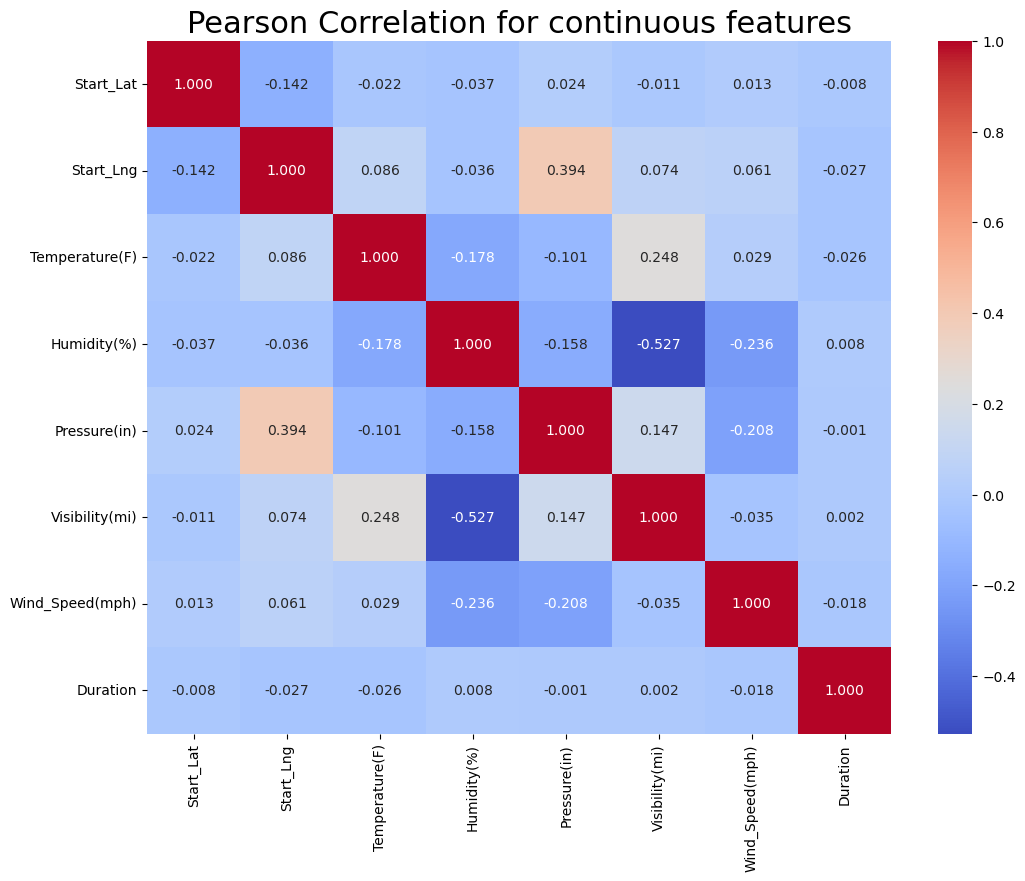

In [142]:
def style_corr(v, props=''):
    return props if (v < -0.4 or v > 0.4) and v != 1 else None

continuous_feature = ['Start_Lat', 'Start_Lng', 'Temperature(F)','Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Duration']
data_modelling_df[continuous_feature].corr().style.map(style_corr, props='color:red;')

# Show the heatmap
plt.figure(figsize=(12,9))
sns.heatmap(data_modelling_df[continuous_feature].corr(), cmap="coolwarm", annot = True, fmt='.3f').set_title('Pearson Correlation for continuous features', fontsize=22)

Step 6: Drop rows with the same value (continuous features)

In [143]:
# Find the data with all the same value and drop
unique_counts = data_modelling_df.drop(continuous_feature, axis=1).astype("object").describe().loc['unique']
feature_all_same = list(unique_counts[unique_counts == 1].index)
data_modelling_df.drop(feature_all_same, axis=1, inplace=True)

Step 7: Correlation analysis for categorical features

In [144]:
# Display the correlation table for categorical features
data_modelling_df.drop(continuous_feature, axis=1).corr(method='spearman').style.map(style_corr, props='color:red;')

,Severity,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Station,Stop,Traffic_Calming,Traffic_Signal,Month,Week,Hour,Weather_Fair,Weather_Cloudy,Weather_Clear,Weather_Overcast,Weather_Snow,Weather_Haze,Weather_Rain,Weather_Thunderstorm,Weather_Windy,Weather_Hail,Weather_Thunder,Wind_C,Wind_E,Wind_N,Wind_S,Wind_V,Wind_W
Severity,1.000000,-0.080831,-0.012215,-0.175514,-0.036221,0.102516,-0.004179,-0.019369,-0.137824,-0.126599,-0.013109,-0.177605,-0.039663,0.019422,-0.006993,-0.034788,-0.020390,0.009156,0.039075,0.027714,0.003453,0.047988,0.009114,0.015029,0.001980,0.004836,-0.003997,0.011244,0.016061,-0.015943,-0.014476,-0.000061
Amenity,-0.080831,1.000000,0.053447,0.329982,0.013593,-0.028653,0.002136,0.169364,0.194568,0.064558,0.047387,0.225109,0.008131,-0.015082,0.020114,-0.044625,0.055867,-0.005278,-0.004639,-0.022855,-0.011707,0.009796,-0.008721,0.026051,-0.001949,-0.001160,-0.049308,0.036019,0.000947,0.009757,-0.022434,0.009119
Bump,-0.012215,0.053447,1.000000,0.027332,0.028199,-0.007047,-0.000647,-0.002294,0.010474,-0.004965,0.904486,0.003078,0.005527,0.008457,-0.000263,-0.005701,0.005483,-0.000528,-0.002081,-0.005101,0.003507,0.003017,-0.000872,0.010071,-0.000195,-0.001115,-0.004203,0.007530,-0.004981,-0.000907,-0.003977,0.005377
Crossing,-0.175514,0.329982,0.027332,1.000000,0.040553,-0.108962,0.029200,0.153662,0.307131,0.138871,0.034919,0.479081,0.009174,-0.032727,0.032657,-0.057325,0.080654,-0.010410,-0.010886,-0.039940,-0.005561,0.004071,-0.002554,0.048896,-0.003843,-0.007661,-0.058194,0.041512,-0.001164,0.009926,-0.032022,0.017848
Give_Way,-0.036221,0.013593,0.028199,0.040553,1.000000,-0.024047,-0.002413,0.004056,-0.010083,0.013304,0.025150,0.052218,0.011243,0.001438,-0.000910,0.001289,0.001215,-0.001970,-0.004296,-0.001285,-0.010106,0.003741,0.004961,0.004253,-0.000727,-0.004161,0.001773,0.009138,-0.000464,0.000194,0.003750,-0.009514
Junction,0.102516,-0.028653,-0.007047,-0.108962,-0.024047,1.000000,-0.009543,0.000253,-0.088644,-0.060234,-0.007791,-0.129162,-0.022924,0.018561,-0.013767,0.011697,-0.021859,0.011008,0.000068,0.000586,-0.004944,0.018682,-0.008317,-0.001821,-0.002876,-0.009327,0.003004,0.002090,0.014058,-0.006017,-0.007149,-0.009564
No_Exit,-0.004179,0.002136,-0.000647,0.029200,-0.002413,-0.009543,1.000000,-0.003106,0.003582,0.014032,-0.000715,-0.003801,-0.006799,0.003225,-0.005309,-0.015330,0.013898,-0.000715,-0.002819,-0.006909,0.000276,0.008202,-0.001181,0.015361,-0.000264,-0.001511,0.003127,0.006422,0.006421,-0.008228,0.009887,-0.009771
Railway,-0.019369,0.169364,-0.002294,0.153662,0.004056,0.000253,-0.003106,1.000000,0.209434,-0.003751,-0.002536,0.111926,0.001327,-0.004444,0.005811,-0.030073,0.032921,-0.002536,-0.004585,-0.003739,-0.007358,0.004722,0.002218,0.026800,-0.000936,-0.005358,-0.029577,0.018966,0.002322,0.009198,-0.014754,0.002758
Station,-0.137824,0.194568,0.010474,0.307131,-0.010083,-0.088644,0.003582,0.209434,1.000000,0.059122,0.008118,0.370255,0.015297,-0.025337,0.031439,-0.030250,0.054224,-0.007462,-0.012476,-0.032167,-0.010917,-0.001491,-0.000531,0.033509,-0.002755,-0.002834,-0.034129,0.016213,-0.000369,0.012553,-0.032717,0.015261
Stop,-0.126599,0.064558,-0.004965,0.138871,0.013304,-0.060234,0.014032,-0.003751,0.059122,1.000000,-0.000406,-0.065621,-0.001455,-0.006372,0.029730,-0.003326,0.010058,-0.000406,-0.004732,-0.011455,0.002787,-0.002252,-0.002910,-0.004648,-0.002026,0.002869,-0.002472,-0.000518,-0.003962,0.006568,-0.001631,0.000467


Text(0.5, 1.0, 'Spearman Correlation for categorical features')

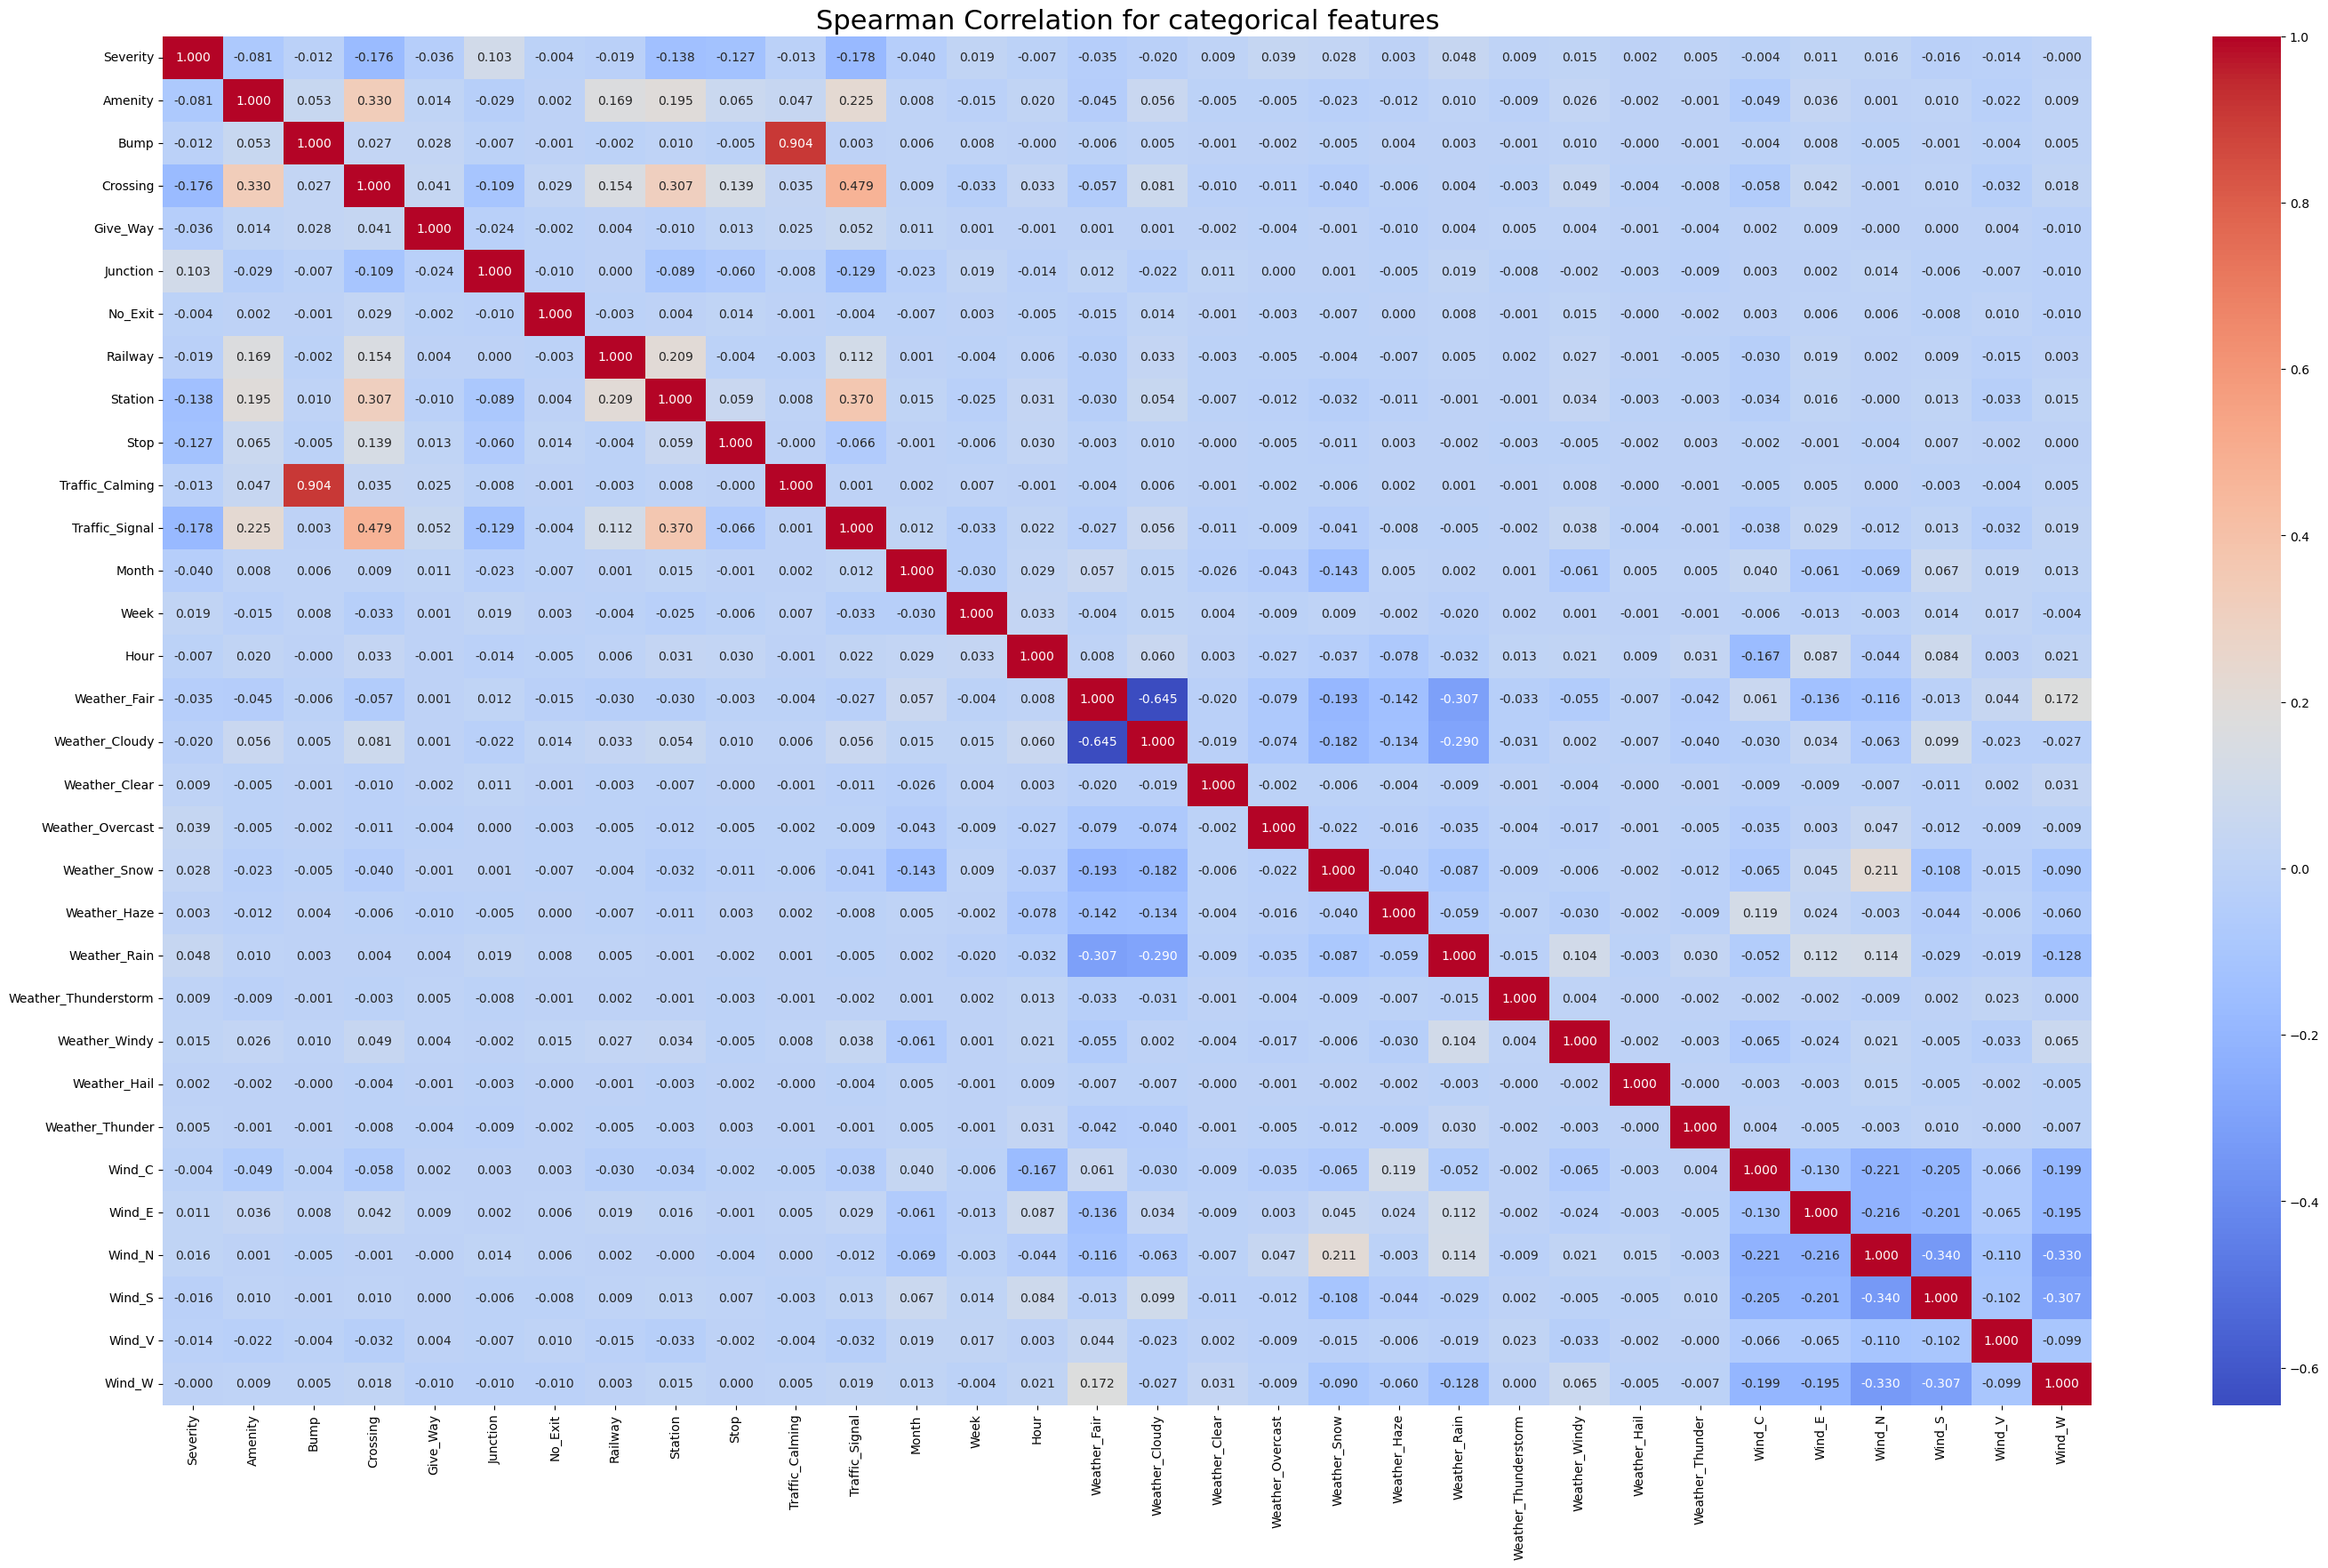

In [145]:
# Show the heatmap
plt.figure(figsize=(35,20))
sns.heatmap(data_modelling_df.drop(continuous_feature, axis=1).corr(method='spearman'), cmap="coolwarm", annot = True, fmt='.3f').set_title('Spearman Correlation for categorical features', fontsize=22)

In [146]:
data_modelling_df.columns

Index(['Severity', 'Start_Lat', 'Start_Lng', 'Temperature(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Amenity', 'Bump',
       'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Duration', 'Month',
       'Week', 'Hour', 'Weather_Fair', 'Weather_Cloudy', 'Weather_Clear',
       'Weather_Overcast', 'Weather_Snow', 'Weather_Haze', 'Weather_Rain',
       'Weather_Thunderstorm', 'Weather_Windy', 'Weather_Hail',
       'Weather_Thunder', 'Wind_C', 'Wind_E', 'Wind_N', 'Wind_S', 'Wind_V',
       'Wind_W'],
      dtype='object')

In [147]:
data_modelling_df.head(5)

,Severity,Start_Lat,Start_Lng,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Amenity,Bump,...,Weather_Thunderstorm,Weather_Windy,Weather_Hail,Weather_Thunder,Wind_C,Wind_E,Wind_N,Wind_S,Wind_V,Wind_W
3,4,42.495930,-71.178238,46.0,89.0,30.01,3.0,8.1,0,0,...,0,0,0,0,False,True,False,False,False,False
4,3,42.525875,-70.972115,46.0,100.0,29.97,6.0,8.1,0,0,...,0,0,0,0,False,False,True,False,False,False
6,2,42.251457,-71.002701,44.1,100.0,29.96,10.0,17.3,0,0,...,0,0,0,0,False,True,False,False,False,False
7,2,42.619003,-71.125229,45.0,97.0,29.98,7.0,8.1,0,0,...,0,0,0,0,False,True,False,False,False,False
9,2,42.770470,-71.075432,46.0,96.0,29.97,8.0,6.9,0,0,...,0,0,0,0,False,True,False,False,False,False


Step 8: Split Data

In [148]:
# Define features (X) and target variable (y)
X = data_modelling_df.drop(columns=["Severity"])  
y = data_modelling_df["Severity"] 

# Split into training (70%) and temp (30%) using stratification
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Split temp set into validation (15%) and test (15%) using stratification
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Print dataset distribution
print("Training set distribution:\n", y_train.value_counts(normalize=True))
print("\nValidation set distribution:\n", y_val.value_counts(normalize=True))
print("\nTest set distribution:\n", y_test.value_counts(normalize=True))

Training set distribution:
 Severity
2    0.706796
3    0.244488
1    0.039018
4    0.009698
Name: proportion, dtype: float64

Validation set distribution:
 Severity
2    0.706912
3    0.244476
1    0.038890
4    0.009722
Name: proportion, dtype: float64

Test set distribution:
 Severity
2    0.706735
3    0.244476
1    0.039067
4    0.009722
Name: proportion, dtype: float64


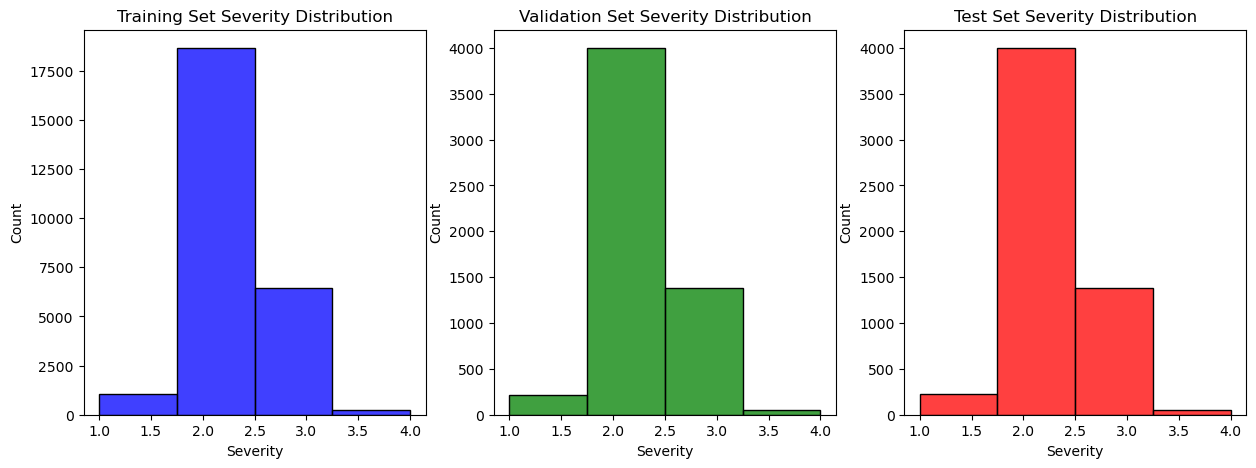

In [149]:
# Plot class distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(y_train, bins=4, ax=axes[0], kde=False, color="blue")
axes[0].set_title("Training Set Severity Distribution")

sns.histplot(y_val, bins=4, ax=axes[1], kde=False, color="green")
axes[1].set_title("Validation Set Severity Distribution")

sns.histplot(y_test, bins=4, ax=axes[2], kde=False, color="red")
axes[2].set_title("Test Set Severity Distribution")

plt.show()

In [150]:
# Save Training Set
X_train.to_csv("X_train.csv", index=False)
y_train.to_csv("y_train.csv", index=False)

# Save Validation Set
X_val.to_csv("X_val.csv", index=False)
y_val.to_csv("y_val.csv", index=False)

# Save Test Set
X_test.to_csv("X_test.csv", index=False)
y_test.to_csv("y_test.csv", index=False)